<a href="https://colab.research.google.com/github/Mishabz4321/DEEP-LEARNING/blob/main/Potato_Disease_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing Necessary Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# to prevent unnecessary warnings 
import warnings 
warnings.simplefilter(action='ignore', category=FutureWarning)  
# TensorFlow and tf.keras
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import files
files.upload()

{}

## Loading Data from kaggle

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# importing data from Kaggle into Google Colab
! kaggle datasets download arjuntejaswi/plant-village

 98% 321M/329M [00:06<00:00, 47.1MB/s]
100% 329M/329M [00:06<00:00, 51.9MB/s]


In [ ]:
 # Unzip the file
!unzip /content/plant-village.zip

Streaming output truncated to the last 5000 lines.
  inflating: PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08c033bd-fbc3-445a-88d1-1863070e52ce___YLCV_GCREC 2872.JPG  
  inflating: PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08dd176c-e9d9-4746-92c3-fa8dc9074347___UF.GRC_YLCV_Lab 03057.JPG  
  inflating: PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08f78a80-46f5-45a6-937c-4d05d61c08c2___UF.GRC_YLCV_Lab 01895.JPG  
  inflating: PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0903aa95-6e8a-4abd-a003-126fcd9a5493___YLCV_GCREC 2806.JPG  
  inflating: PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0911d416-d73d-4c2a-8e45-207a7ceb7c9a___YLCV_GCREC 2773.JPG  
  inflating: PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/09188838-cc89-4925-94c5-d9563c4cb4bf___UF.GRC_YLCV_Lab 02974.JPG  
  inflating: PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0922e026-b563-438d-b9ed-7476153023ce___YLCV_GCREC 2258.JPG  
  inflating: PlantVillage/Tomato__Tomato_YellowLeaf__Cur

In [ ]:
# Removing data other than potato
import shutil
shutil.rmtree('//content/PlantVillage/Pepper__bell___Bacterial_spot')
shutil.rmtree('//content/PlantVillage/Pepper__bell___healthy')
shutil.rmtree('//content/PlantVillage/Tomato_Bacterial_spot')
shutil.rmtree('//content/PlantVillage/Tomato_Early_blight')
shutil.rmtree('//content/PlantVillage/Tomato_Late_blight')
shutil.rmtree('//content/PlantVillage/Tomato_Leaf_Mold')
shutil.rmtree('//content/PlantVillage/Tomato_Septoria_leaf_spot')
shutil.rmtree('//content/PlantVillage/Tomato_Spider_mites_Two_spotted_spider_mite')
shutil.rmtree('//content/PlantVillage/Tomato__Target_Spot')
shutil.rmtree('//content/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus')
shutil.rmtree('//content/PlantVillage/Tomato__Tomato_mosaic_virus')
shutil.rmtree('//content/PlantVillage/Tomato_healthy')

## Import Data into Tensorflow Dataset Object

In [ ]:
## Defining Some Constants
IMG_SIZE= 256
CHANNELS= 3
BATCH_SIZE= 32
EPOCHS= 50

In [ ]:

potato = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [ ]:
class_names= potato.class_names
print(class_names)

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


In [ ]:
# size of dataset
print('no of batches:', len(potato))

no of batches: 68


In [ ]:
for image_batch, labels_batch in potato.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


## Visualize some mage from dataset

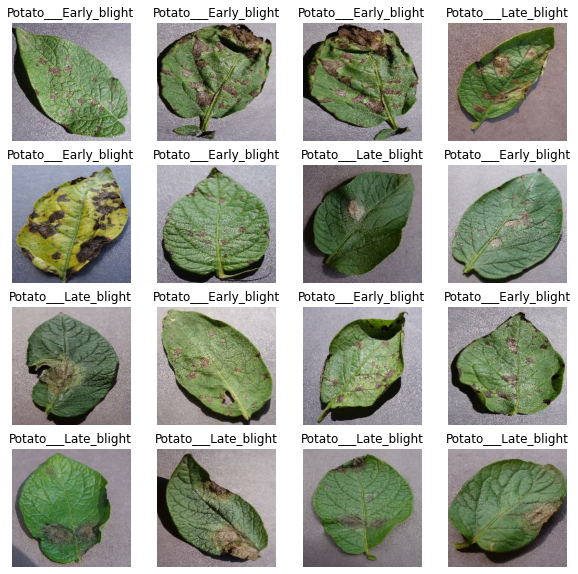

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in potato.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis('off')

## Split into Train, Validation and Test
--> Training: Dataset to be used while training

--> Validation: Dataset to be tested against while training (Minimising loss)

--> Test: Dataset to be tested against after we trained a model

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, 
                              test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds= get_dataset_partitions_tf(potato)

In [ ]:
print('no.of training data:', len(train_ds))
print('no.of validation data:', len(val_ds))
print('no.of test data:',len(test_ds))

no.of training data: 54
no.of validation data: 6
no.of test data: 8


##### 54, 6, 8 are actually batches of size of 32

## Cache, Shuffle, and Prefetch the Dataset¶(Optimisation of Tensorflow input Pipeline)

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Model Building

#### Create a layer for resizing and normalising of data

In [ ]:
resize_normalize= tf.keras.Sequential(
  [layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
                                       layers.experimental.preprocessing.Rescaling(1./255),])

## Data Augmentation
###### Perform Data Augmentation when we have less data. It will boost your model aacuracy

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

### Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

In [ ]:
input_shape = (BATCH_SIZE, IMG_SIZE, IMG_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_normalize,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='tanh', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='tanh'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='tanh'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='tanh'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='tanh'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='tanh'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='tanh'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 60, 60, 64)         

## Compile Model
We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, 
                                               restore_best_weights=True,
                                               verbose=1)
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    callbacks=[es_callback],
    epochs=50
)

Epoch 1/50
54/54 [==============================] - 43s 191ms/step - loss: 0.6976 - accuracy: 0.6777 - val_loss: 0.4549 - val_accuracy: 0.8021
Epoch 2/50
54/54 [==============================] - 7s 134ms/step - loss: 0.4068 - accuracy: 0.8385 - val_loss: 0.2644 - val_accuracy: 0.9115
Epoch 3/50
54/54 [==============================] - 7s 133ms/step - loss: 0.2417 - accuracy: 0.9097 - val_loss: 0.2209 - val_accuracy: 0.9167
Epoch 4/50
54/54 [==============================] - 7s 135ms/step - loss: 0.1647 - accuracy: 0.9317 - val_loss: 0.1854 - val_accuracy: 0.9323
Epoch 5/50
54/54 [==============================] - 7s 134ms/step - loss: 0.1942 - accuracy: 0.9225 - val_loss: 0.2572 - val_accuracy: 0.8594
Epoch 6/50
54/54 [==============================] - 7s 135ms/step - loss: 0.1203 - accuracy: 0.9595 - val_loss: 0.1144 - val_accuracy: 0.9583
Epoch 7/50
54/54 [==============================] - 7s 135ms/step - loss: 0.1063 - accuracy: 0.9635 - val_loss: 0.3981 - val_accuracy: 0.8646
Epoch

In [ ]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 0s 59ms/step - loss: 0.0776 - accuracy: 0.9805


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

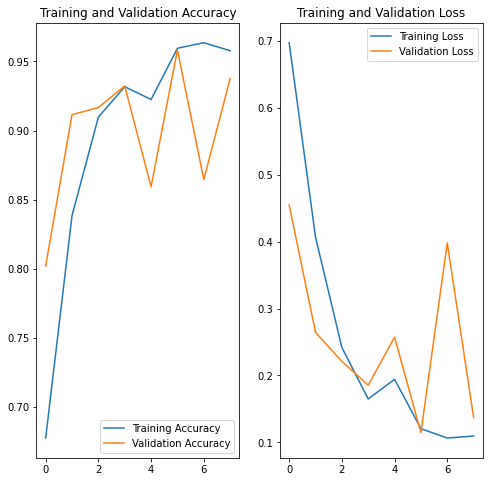

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(8), acc, label='Training Accuracy')
plt.plot(range(8), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(8), loss, label='Training Loss')
plt.plot(range(8), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

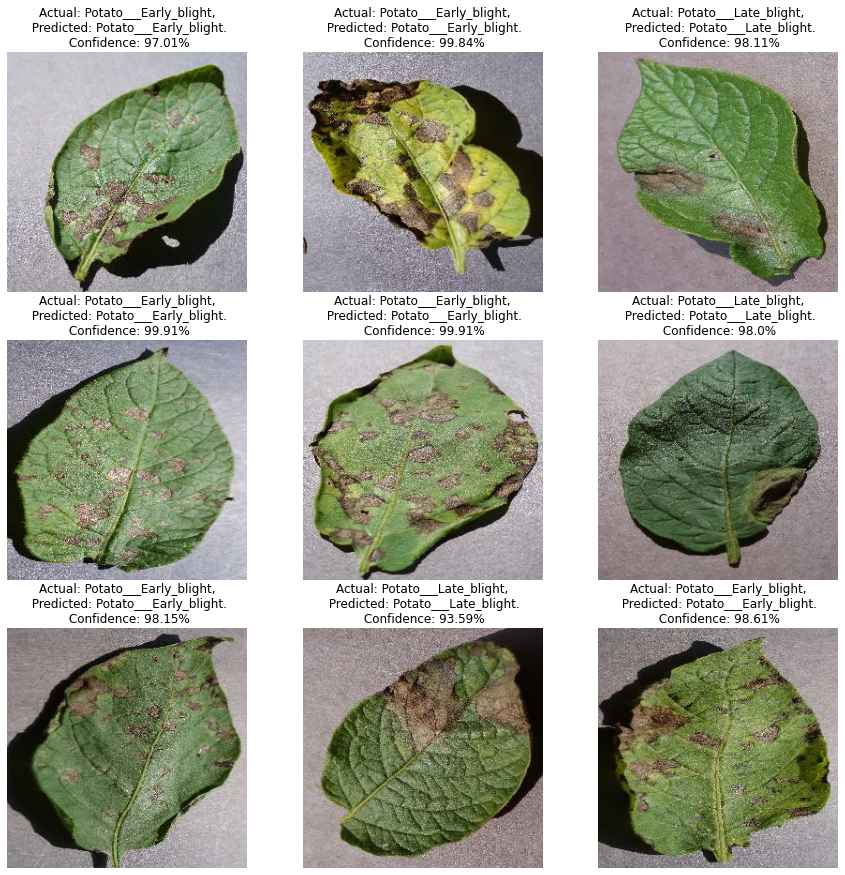

In [ ]:

plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [ ]:
model.save("../potatoes.h5")